In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob import TextBlob , Word
import re 
import string

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
! unzip ../input/sentiment-analysis-on-movie-reviews/test.tsv.zip
! unzip ../input/sentiment-analysis-on-movie-reviews/train.tsv.zip

Archive:  ../input/sentiment-analysis-on-movie-reviews/test.tsv.zip
  inflating: test.tsv                
Archive:  ../input/sentiment-analysis-on-movie-reviews/train.tsv.zip
  inflating: train.tsv               


In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [5]:
train=pd.read_csv('./train.tsv', sep='\t')
test=pd.read_csv('./test.tsv', sep='\t')

In [6]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [7]:
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [8]:
df= train.append(test)
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1.0
1,2,1,A series of escapades demonstrating the adage ...,2.0
2,3,1,A series,2.0
3,4,1,A,2.0
4,5,1,series,2.0
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",NaN
66288,222349,11855,"A long-winded , predictable scenario",NaN
66289,222350,11855,"A long-winded ,",NaN
66290,222351,11855,A long-winded,NaN


## Data clean

In [9]:
df['Phrase']=df['Phrase'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','').str.replace("[^a-zA-Z0-9\s]",'') 

In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer_output = WordNetLemmatizer()

df['Phrase'] = df['Phrase'].apply(lambda x : word_tokenize(x.lower())) # cumle -> words
df["Phrase"] = df["Phrase"].apply(lambda x : [word for word in x if word not in STOPWORDS]) # stop words cikarma
df["Phrase"] = df["Phrase"].apply(lambda x : [lemmatizer_output.lemmatize(word) for word in x]) # kelimelerin kok halleri
df["Phrase"] = df["Phrase"].apply(lambda x : " ".join(x)) # kelimleri birleştirdik

## Word Cloud

In [11]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=4, contour_width=3, contour_color='steelblue')
    wc.generate(" ".join(data)) # tum kelimeleri birlestirip tek 1 string haline getirir
    plt.imshow(wc)
    plt.axis("off")

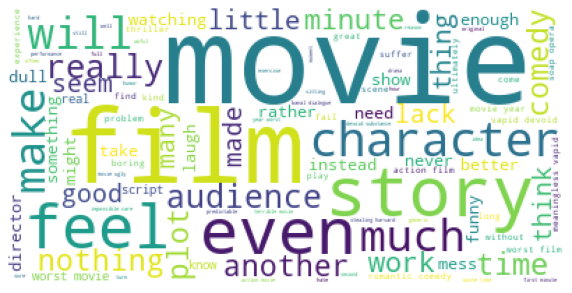

In [12]:
# 0
wc(df[df.Sentiment==0.0].Phrase, 'white')

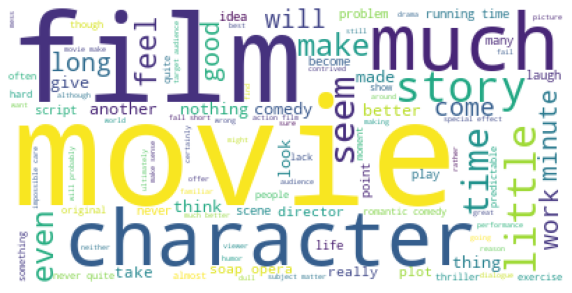

In [13]:
# 1
wc(df[df.Sentiment==1.0].Phrase, 'white')

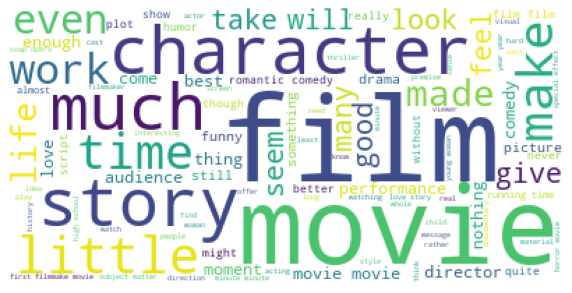

In [14]:
# 2
wc(df[df.Sentiment==2.0].Phrase, 'white')

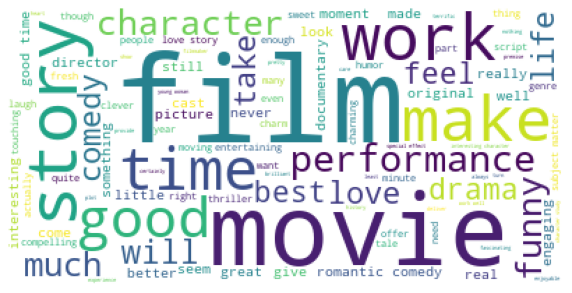

In [15]:
# 3
wc(df[df.Sentiment==3.0].Phrase, 'white')

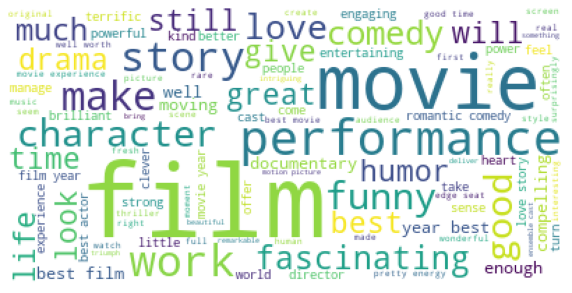

In [16]:
# 4
wc(df[df.Sentiment==4.0].Phrase, 'white')

In [17]:
def word_cleaner(data):
    words=[re.sub("[^a-zA-Z]"," ",i)for i in data] # noktalamalı kaldır
    words=[i.lower()for j in words for i in j.split()]#Splitting all the sentences into words# cümleleri kelimeye dönüştür
    words=[i for i in words if not i in set(stopwords.words("english"))]#removing stopwords
    words=[i for i in words if len(i)>2 ]#2 den büyük kelimeleri al # bu ozellik wordcloud da zaten var aslinda
    return words

In [18]:
words_freq = pd.DataFrame(nltk.FreqDist(word_cleaner(df.Phrase)).most_common(10), columns=['Top Words', 'Frequency'])

<AxesSubplot:xlabel='Top Words', ylabel='Frequency'>

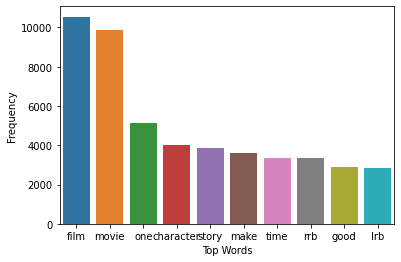

In [19]:
sns.barplot(x="Top Words",y="Frequency",data=words_freq)

<AxesSubplot:ylabel='Sentiment'>

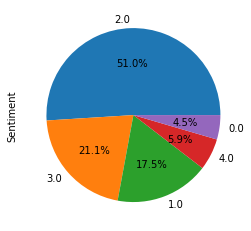

In [20]:
df["Sentiment"].value_counts().plot.pie(autopct="%1.1f%%")

## Machine Learning (Takes too long)

In [21]:
def nlp_analysis(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
    
    vectorizers=[CountVectorizer(), TfidfVectorizer()]
    ngrams = [(1,1), (1,2)]
    
    classifiers=[ XGBClassifier()]
    
    col_names = ['Classifier','Methods', 'N-Grams','Accuracy','Precision','Recall', 'F1']
    df_nlp = pd.DataFrame(columns=col_names)   
    
    for i in vectorizers:
        vec=i
        vec_name = i.__class__.__name__
        vec.stop_words='english'
        
        for j in ngrams:
            vec.ngram_range=j
            X_train_dtm = vec.fit_transform(X_train)
            X_test_dtm = vec.transform(X_test)
            
            for k in classifiers:
                pred = k.fit(X_train_dtm, y_train).predict(X_test_dtm)
                clas_name = k.__class__.__name__
                
                accuracy = accuracy_score(y_test, pred)
                precision = precision_score(y_test, pred, average='weighted')
                f1 = f1_score(y_test, pred, average='weighted')
                recall = recall_score(y_test, pred, average='weighted')
                
                df_entry = pd.DataFrame([[clas_name, vec_name, j, accuracy*100, precision*100, recall*100, f1*100]], 
                                        columns=col_names)
                df_nlp=df_nlp.append(df_entry)
    return df_nlp

In [22]:
#df_train = df[:train.shape[0]]
#df_test = df[train.shape[0]:]

In [23]:
#nlp_analysis(df_train.Phrase,df_train.Sentiment.astype(int))
# ML algoitmalari cok veride yavas calisiyor

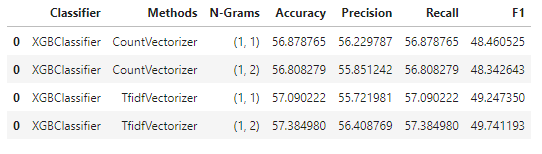

## Deep Learning

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['Phrase'].values)
sequences = tokenizer.texts_to_sequences(df['Phrase'].values)
df_dtm=pad_sequences(sequences, maxlen=200)

df_train_dtm = df_dtm[:train.shape[0]]
df_test_dtm = df_dtm[train.shape[0]:]

In [25]:
#cv = CountVectorizer(min_df=0.0005, ngram_range=(1,2), stop_words="english")
#df_dtm = cv.fit_transform(df['Phrase']).toarray()
#df_dtm = pd.DataFrame(df_dtm.toarray(), columns=cv.get_feature_names_out())
#df_dtm.loc[:, 'polar'] = df.Polarity.values
#df_train_dtm = df_dtm[:train.shape[0]]
#df_test_dtm = df_dtm[train.shape[0]:]

In [26]:
df_dtm.shape

(222352, 200)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization

model=Sequential()
model.add(Embedding(20000, 500, input_length=df_train_dtm.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))
model.summary() 

2022-08-27 08:47:50.072344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:47:50.210682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:47:50.211444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:47:50.213316: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 500)          10000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               289280    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2

In [28]:
from tensorflow.keras.utils import to_categorical
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(df_train_dtm, to_categorical(train.Sentiment.values), validation_split=0.20, epochs=10, batch_size=289, verbose=1)

2022-08-27 08:47:53.250652: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
432/432 [==============================] - 155s 353ms/step - loss: 1.2813 - accuracy: 0.5178 - val_loss: 1.3381 - val_accuracy: 0.4922
Epoch 2/10
432/432 [==============================] - 154s 357ms/step - loss: 0.9197 - accuracy: 0.6352 - val_loss: 1.2265 - val_accuracy: 0.4965
Epoch 3/10
432/432 [==============================] - 153s 355ms/step - loss: 0.8285 - accuracy: 0.6649 - val_loss: 1.2355 - val_accuracy: 0.5005
Epoch 4/10
432/432 [==============================] - 153s 354ms/step - loss: 0.7768 - accuracy: 0.6822 - val_loss: 1.2190 - val_accuracy: 0.5180
Epoch 5/10
432/432 [==============================] - 153s 355ms/step - loss: 0.7346 - accuracy: 0.6970 - val_loss: 1.2487 - val_accuracy: 0.5294
Epoch 6/10
432/432 [==============================] - 156s 360ms/step - loss: 0.7052 - accuracy: 0.7094 - val_loss: 1.2615 - val_accuracy: 0.5137
Epoch 7/10
432/432 [==============================] - 154s 357ms/step - loss: 0.6778 - accuracy: 0.7186 - val_loss: 1.2314 -

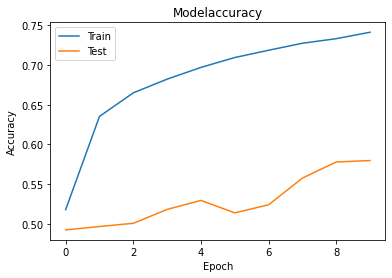

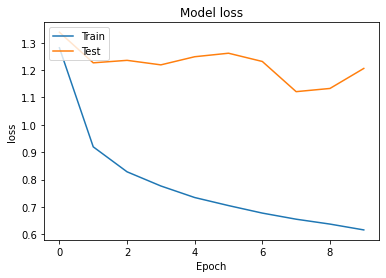

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Modelaccuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

In [30]:
pred=model.predict(df_test_dtm)

In [31]:
np.argmax(pred, axis=1)

array([3, 3, 2, ..., 1, 1, 2])

In [32]:
submission = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
submission.loc[:, 'Sentiment'] = np.argmax(pred, axis=1)
submission.to_csv('submission.csv', index=False)
submission.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
